# Intraday Strategy, Part 2: Model Training & Signal Evaluation

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) and use the features engineered in the last notebook to train gradient boosting model that predicts the returns for the NASDAQ100 stocks over the next 1-minute bar. 

> Note that we will assume throughout that we can always buy (sell) at the first (last) trade price for a given bar at no cost and without market impact. This does certainly not reflect market reality, and is rather due to the challenges of simulating a trading strategy at this much higher intraday frequency in a realistic manner using open-source tools.

Note also that this section has slightly changed from the version published in the book to permit replication using the Algoseek data sample.

In [26]:
%sudo apt install cmake
%uv pip install "lightgbm==3.3.5" --no-binary lightgbm --config-setting=cmake.define.USE_CUDA=ON 
%uv pip install tables


Usage:   
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] [-e] <vcs project url> ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] [-e] <local project path> ...
  /home/jim/.cache/uv/archive-v0/aWg7grEuJ9_NpgJY_Vt8J/bin/python -m pip install [options] <archive url/path> ...

no such option: --install-option
Note: you may need to restart the kernel to use updated packages.


## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import sys, os
from pathlib import Path
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

Ensuring we can import `utils.py` in the repo's root directory:

In [3]:
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [5]:
# where we stored the features engineered in the previous notebook
data_store = '../data/nasdaq100/algoseek.h5'

In [6]:
# where we'll store the model results
result_store = 'results/intra_day.h5'

In [7]:
# here we save the trained models
model_path = Path('models/intraday')
if not model_path.exists():
    model_path.mkdir(parents=True)

## Load Model Data

In [8]:
data = pd.read_hdf(data_store, 'model_data')

In [9]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 22 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   minute          30875649 non-null  int64  
 1   ret1min         30612848 non-null  float64
 2   ret2min         30302846 non-null  float64
 3   ret3min         30220887 non-null  float64
 4   ret4min         30141503 non-null  float64
 5   ret5min         30063236 non-null  float64
 6   ret6min         29983969 non-null  float64
 7   ret7min         29903822 non-null  float64
 8   ret8min         29824607 non-null  float64
 9   ret9min         29745431 non-null  float64
 10  ret10min        29666821 non-null  float64
 11  fwd1min         30875649 non-null  float64
 12  rup             30083777 non-null  float64
 13  rdown           30083777 non-null  float64
 14  BOP             30612848 non-null  flo

In [10]:
data.sample(frac=.1).describe(percentiles=np.arange(.1, 1, .1))

,minute,ret1min,ret2min,ret3min,ret4min,ret5min,ret6min,ret7min,ret8min,ret9min,...,rup,rdown,BOP,CCI,MFI,STOCHRSI,slowd,slowk,NATR,trades_bid_ask
count,3.087565e+06,3.061353e+06,3.030366e+06,3.022232e+06,3.014597e+06,3.006284e+06,2.998549e+06,2.990669e+06,2.982548e+06,2.974617e+06,...,3.008146e+06,3.008146e+06,3.061353e+06,2.851720e+06,3.087377e+06,3.087164e+06,3.087329e+06,3.087329e+06,3.087377e+06,3.008146e+06
mean,1.944517e+02,-2.933200e-06,-1.869810e-06,-1.598179e-06,-1.981696e-06,-1.142065e-06,3.964908e-08,8.709935e-07,1.473304e-06,8.600771e-07,...,5.109800e-01,5.258520e-01,-2.657472e-03,1.926504e-01,4.995851e+01,4.996170e+01,5.026232e+01,5.025505e+01,9.574717e-02,-7.094037e-03
std,1.127876e+02,8.522094e-04,1.143481e-03,1.364755e-03,1.554875e-03,1.717925e-03,1.863826e-03,1.994273e-03,2.115630e-03,2.235502e-03,...,7.497976e+00,3.099559e+01,6.268154e-01,1.088541e+02,1.969340e+01,3.548760e+01,2.770983e+01,2.860330e+01,7.538252e-02,2.717903e+01
min,0.000000e+00,-1.244796e-01,-8.829405e-02,-1.060236e-01,-1.327945e-01,-1.545420e-01,-1.956444e-01,-2.158158e-01,-1.726063e-01,-2.157102e-01,...,0.000000e+00,0.000000e+00,-1.000000e+00,-4.666667e+02,-1.837897e-08,0.000000e+00,-3.910354e-12,-5.092223e-12,2.026288e-07,-2.630100e+04
10%,3.800000e+01,-7.494558e-04,-1.048584e-03,-1.268377e-03,-1.454229e-03,-1.616089e-03,-1.762741e-03,-1.897606e-03,-2.026686e-03,-2.142857e-03,...,0.000000e+00,0.000000e+00,-9.000000e-01,-1.377555e+02,2.395492e+01,0.000000e+00,1.250572e+01,1.122968e+01,4.014445e-02,-7.299035e-01
20%,7.700000e+01,-4.105090e-04,-5.929791e-04,-7.232152e-04,-8.290892e-04,-9.218753e-04,-1.004307e-03,-1.081334e-03,-1.153403e-03,-1.218621e-03,...,9.638554e-02,9.944259e-02,-6.644518e-01,-9.983731e+01,3.237073e+01,9.771635e+00,2.094136e+01,1.994344e+01,4.871973e-02,-4.601227e-01
30%,1.160000e+02,-2.308225e-04,-3.375865e-04,-4.100041e-04,-4.732608e-04,-5.260389e-04,-5.755245e-04,-6.196361e-04,-6.601532e-04,-6.987242e-04,...,1.976744e-01,2.017393e-01,-4.508475e-01,-6.917500e+01,3.883638e+01,2.365167e+01,3.006536e+01,2.936605e+01,5.665948e-02,-2.782861e-01
40%,1.550000e+02,-9.680542e-05,-1.555210e-04,-1.871257e-04,-2.161311e-04,-2.398082e-04,-2.604845e-04,-2.820079e-04,-3.003003e-04,-3.175107e-04,...,2.857143e-01,2.916667e-01,-1.826087e-01,-3.702543e+01,4.452486e+01,3.687606e+01,3.997666e+01,3.958910e+01,6.520095e-02,-1.309554e-01
50%,1.940000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.701016e-01,3.759077e-01,0.000000e+00,4.377638e-01,4.989353e+01,4.993994e+01,5.029630e+01,5.008741e+01,7.514502e-02,0.000000e+00
60%,2.340000e+02,9.104980e-05,1.499700e-04,1.805591e-04,2.082899e-04,2.328158e-04,2.537642e-04,2.754062e-04,2.960551e-04,3.132832e-04,...,4.578505e-01,4.638802e-01,1.666667e-01,3.785810e+01,5.529671e+01,6.304218e+01,6.069305e+01,6.111111e+01,8.752835e-02,1.036810e-01


## Model Training

### Helper functions

In [11]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


In [12]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Categorical Variables

In [13]:
data['stock_id'] = pd.factorize(data.index.get_level_values('ticker'), sort=True)[0]

In [14]:
categoricals = ['stock_id']

### Custom Metric

In [15]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Cross-validation setup

In [16]:
DAY = 390   # number of minute bars in a trading day of 6.5 hrs (9:30 - 15:59)
MONTH = 21  # trading days

In [17]:
def get_cv(n_splits=23):
    return MultipleTimeSeriesCV(n_splits=n_splits,
                                lookahead=1,
                                test_period_length=MONTH * DAY,       # test for 1 month
                                train_period_length=12 * MONTH * DAY,  # train for 1 year
                                date_idx='date_time')

Show train/validation periods:

In [18]:
for i, (train_idx, test_idx) in enumerate(get_cv().split(X=data)):
    train_dates = data.iloc[train_idx].index.unique('date_time')
    test_dates = data.iloc[test_idx].index.unique('date_time')
    print(train_dates.min(), train_dates.max(), test_dates.min(), test_dates.max())

2016-11-29 15:59:00 2017-11-29 15:59:00 2017-11-30 09:30:00 2017-12-29 15:59:00
2016-10-28 15:47:00 2017-10-30 15:58:00 2017-10-30 15:59:00 2017-11-29 15:59:00
2016-09-29 15:47:00 2017-09-29 15:58:00 2017-09-29 15:59:00 2017-10-30 15:58:00
2016-08-30 15:47:00 2017-08-30 15:58:00 2017-08-30 15:59:00 2017-09-29 15:58:00
2016-08-01 15:47:00 2017-08-01 15:58:00 2017-08-01 15:59:00 2017-08-30 15:58:00
2016-06-30 15:47:00 2017-06-30 15:58:00 2017-06-30 15:59:00 2017-08-01 15:58:00
2016-06-01 15:47:00 2017-06-01 15:58:00 2017-06-01 15:59:00 2017-06-30 15:58:00
2016-05-02 15:47:00 2017-05-02 15:58:00 2017-05-02 15:59:00 2017-06-01 15:58:00
2016-04-01 15:47:00 2017-03-31 15:58:00 2017-03-31 15:59:00 2017-05-02 15:58:00
2016-03-02 15:47:00 2017-03-02 15:58:00 2017-03-02 15:59:00 2017-03-31 15:58:00
2016-02-01 15:47:00 2017-01-31 15:58:00 2017-01-31 15:59:00 2017-03-02 15:58:00
2015-12-30 15:47:00 2016-12-29 15:58:00 2016-12-29 15:59:00 2017-01-31 15:58:00
2015-11-30 15:23:00 2016-11-29 15:58:00 

### Train model

In [19]:
label = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(label).tolist()
label = label[0]

In [20]:
params = dict(objective='regression',
              metric=['rmse'],
              device='gpu',
              max_bin=63,
              gpu_use_dp=False,
              num_leaves=16,
              min_data_in_leaf=500,
              feature_fraction=.8,
              verbose=-1)

In [21]:
num_boost_round = 250

In [22]:
cv = get_cv(n_splits=23) # we have enough data for 23 different test periods

In [23]:
def get_scores(result):
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

The following model-training loop will take more than 10 hours to run and also consumes substantial memory. If you run into resource constraints, you can modify the code, e.g., by:
1. Only loading data required for one iteration.
2. Shortening the training period to require less than one year.

You can also speed up the process by using fewer `n_splits`, which implies longer test periods.

In [24]:
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
    # create lgb train set
    train_set = data.iloc[train_idx, :]
    lgb_train = lgb.Dataset(data=train_set.drop(label, axis=1),
                            label=train_set[label],
                            categorical_feature=categoricals)
    
    # create lgb test set
    test_set = data.iloc[test_idx, :]
    lgb_test = lgb.Dataset(data=test_set.drop(label, axis=1),
                           label=test_set[label],
                           categorical_feature=categoricals, 
                           reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_test],
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      evals_result=evals_result,
                      verbose_eval=50)
    model.save_model((model_path / f'{fold:02}.txt').as_posix())
    
    # get train/valid ic scores
    scores = get_scores(evals_result)
    scores.to_hdf(result_store, f'ic/{fold:02}')
    
    # get feature importance
    fi = get_fi(model)
    fi.to_hdf(result_store, f'fi/{fold:02}')
    
    # generate validation predictions
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, [label]]
    y_test['pred'] = model.predict(X_test)
    y_test.to_hdf(result_store, f'predictions/{fold:02}')
    
    # compute average IC per minute
    by_minute = y_test.groupby(test_set.index.get_level_values('date_time'))
    daily_ic = by_minute.apply(lambda x: spearmanr(x[label], x.pred)[0]).mean()
    print(f'\nFold: {fold:02} | {format_time(time()-start)} | IC per minute: {daily_ic:.2%}\n')

[50]	training's rmse: 0.000696223	training's ic: 0.0385708	valid_1's rmse: 0.000816238	valid_1's ic: 0.0543647
[100]	training's rmse: 0.000695557	training's ic: 0.0438129	valid_1's rmse: 0.000815979	valid_1's ic: 0.0557355
[150]	training's rmse: 0.000695049	training's ic: 0.0467319	valid_1's rmse: 0.000815878	valid_1's ic: 0.0553478
[200]	training's rmse: 0.000694598	training's ic: 0.0494918	valid_1's rmse: 0.000815835	valid_1's ic: 0.0559012
[250]	training's rmse: 0.000694141	training's ic: 0.0515311	valid_1's rmse: 0.000815781	valid_1's ic: 0.0561703

Fold: 01 | 00:15:32 | IC per minute: 5.60%

[50]	training's rmse: 0.000700003	training's ic: 0.037644	valid_1's rmse: 0.000848073	valid_1's ic: 0.0418783
[100]	training's rmse: 0.000699326	training's ic: 0.0427117	valid_1's rmse: 0.000847804	valid_1's ic: 0.0431743
[150]	training's rmse: 0.000698835	training's ic: 0.0458794	valid_1's rmse: 0.000847725	valid_1's ic: 0.0437031
[200]	training's rmse: 0.000698361	training's ic: 0.0484886	va

In [54]:
start

1729155816.5670428

## Signal Evaluation

In [55]:
with pd.HDFStore(result_store) as store:
    pred_keys = [k[1:] for k in store.keys() if k[1:].startswith('pred')]
    cv_predictions = pd.concat([store[k] for k in pred_keys]).sort_index()

In [56]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19648064 entries, ('AAL', Timestamp('2016-02-01 15:47:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 2 columns):
 #   Column   Non-Null Count     Dtype  
---  ------   --------------     -----  
 0   fwd1min  19648064 non-null  float64
 1   pred     19648064 non-null  float64
dtypes: float64(2)
memory usage: 422.6+ MB


In [57]:
time_stamp = cv_predictions.index.get_level_values('date_time')
dates = sorted(np.unique(time_stamp.date))

We have out-of-sample predictions for 484 days from February 2016 through December 2017:

In [58]:
print(f'# Days: {len(dates)} | First: {dates[0]} | Last: {dates[-1]}')

# Days: 484 | First: 2016-02-01 | Last: 2017-12-29


We only use minutes with at least 100 predictions:

In [59]:
n = cv_predictions.groupby('date_time').size()

There are ~700 periods, equivalent to a bit over a single trading day (0.67% of all periods in the sample), with fewer than 100 predictions over the 23 test months:

In [60]:
incomplete_minutes = n[n<100].index

In [61]:
print(f'{len(incomplete_minutes)} ({len(incomplete_minutes)/len(n):.2%})')

1255 (0.67%)


In [62]:
cv_predictions = cv_predictions[~time_stamp.isin(incomplete_minutes)]

In [63]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19571774 entries, ('AAL', Timestamp('2016-02-01 15:47:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 2 columns):
 #   Column   Non-Null Count     Dtype  
---  ------   --------------     -----  
 0   fwd1min  19571774 non-null  float64
 1   pred     19571774 non-null  float64
dtypes: float64(2)
memory usage: 421.0+ MB


### Information Coefficient

#### Across all periods

In [64]:
ic = spearmanr(cv_predictions.fwd1min, cv_predictions.pred)[0]

#### By minute

We are making new predictions every minute, so it makes sense to look at the average performance across all short-term forecasts:

In [65]:
minutes = cv_predictions.index.get_level_values('date_time')
by_minute = cv_predictions.groupby(minutes)

In [66]:
ic_by_minute = by_minute.apply(lambda x: spearmanr(x.fwd1min, x.pred)[0])

minute_ic_mean = ic_by_minute.mean()
minute_ic_median = ic_by_minute.median()

print(f'\nAll periods: {ic:6.2%} | By Minute: {minute_ic_mean: 6.2%} (Median: {minute_ic_median: 6.2%})')


All periods:  2.97% | By Minute:  3.21% (Median:  3.23%)


Plotted as a five-day rolling average, we see that the IC was mostly below the out-of-sample period mean, and increased during the last quarter of 2017 (as reflected in the validation results we observed while training the model).

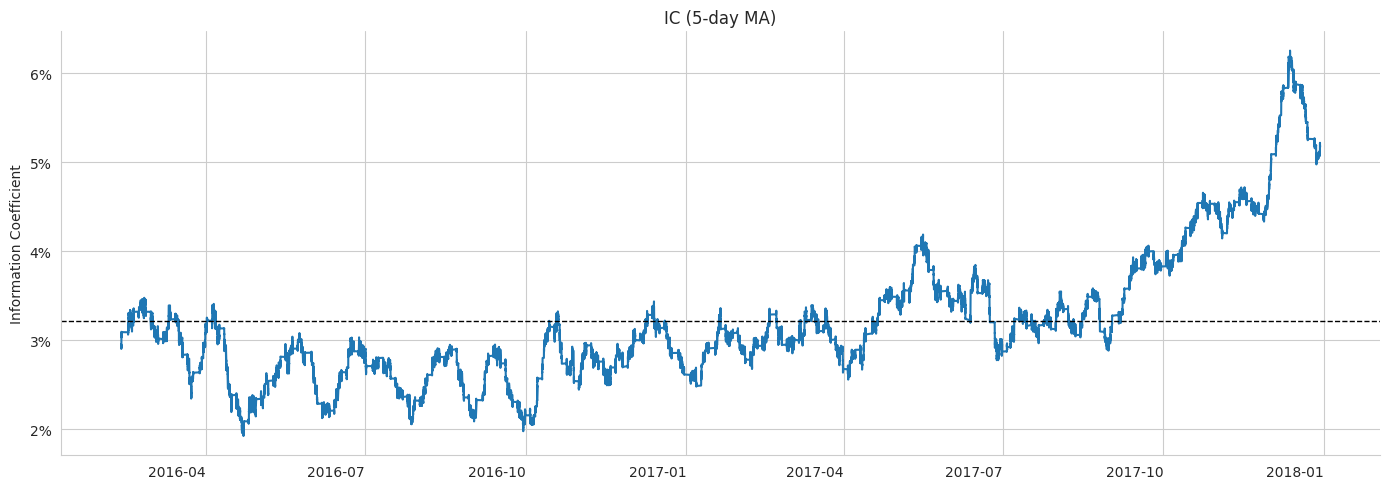

In [67]:
ax = ic_by_minute.rolling(5*650).mean().plot(figsize=(14, 5), title='IC (5-day MA)', rot=0)
ax.axhline(minute_ic_mean, ls='--', lw=1, c='k')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Information Coefficient')
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Vectorized backtest of a naive strategey: financial performance by signal quantile

Alphalens does not work with minute-data, so we need to compute our own signal performance measures.

Unfortunately, Zipline's Pipeline also doesn't work for minute-data and Backtrader takes a very long time with such a large dataset. Hence, instead of an event-driven backtest of entry/exit rules as in previous examples, we can only create a rough sketch of the financial performance of a naive trading strategy driven by the model's predictions using vectorized backtesting (see Chapter 8 on the [ML4T workflow](../08_ml4t_workflow'). As we will see below, this does not produce particularly helpful results.

This naive strategy invests in equal-weighted portfolios of the stocks in each decile under the following assumptions (mentioned at the beginning of this notebook: 
1. Based on the predictions using inputs from the current and previous bars, we can enter positions at the first trade price in the following minute bar
2. We exit all positions at the last price in that following minute bar
3. There are no trading cost or market impact (slippage) of our trades (but we can check how sensitive the results would be).

#### Average returns by minute bar and signal quantile 

To this end, we compute the quintiles and deciles of the model's `fwd1min` predictions for each minute:

In [68]:
by_minute = cv_predictions.groupby(minutes, group_keys=False)

In [69]:
labels = list(range(1, 6))
cv_predictions['quintile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=5, labels=labels).astype(int))

In [70]:
labels = list(range(1, 11))
cv_predictions['decile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=10, labels=labels).astype(int))

In [71]:
cv_predictions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19571774 entries, ('AAL', Timestamp('2016-02-01 15:47:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 4 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   fwd1min   19571774 non-null  float64
 1   pred      19571774 non-null  float64
 2   quintile  19571774 non-null  int64  
 3   decile    19571774 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 719.6+ MB


#### Descriptive statistics of intraday returns by quintile and decile of model predictions

Next, we compute the average one-minute returns for each quintile / decile and minute.

In [72]:
def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
    by_quantile = cv_predictions.reset_index().groupby(['date_time', quantile])
    return by_quantile.fwd1min.mean().unstack(quantile).sort_index()

In [73]:
intraday_returns = {'quintile': compute_intraday_returns_by_quantile(cv_predictions),
                    'decile': compute_intraday_returns_by_quantile(cv_predictions, quantile='decile')}

In [74]:
def summarize_intraday_returns(returns):
    summary = returns.describe(deciles)
    return pd.concat([summary.iloc[:1].applymap(lambda x: f'{x:,.0f}'),
                      summary.iloc[1:].applymap(lambda x: f'{x:.4%}')])

The returns per minute, averaged over the 23-months period, increase by quintile/decile and range from -.3 (-.4) to .27 (.37) basis points for the bottom and top quintile (decile), respectively. While this aligns with the finding of a weakly positive rank correlation coefficient, it also suggests that such small gains are unlikely to survive the impact of trading costs.

In [75]:
summary = summarize_intraday_returns(intraday_returns['quintile'])
summary

quintile,1,2,3,4,5
count,"187,115","187,115","187,115","187,115","187,115"
mean,-0.0030%,-0.0011%,-0.0002%,0.0007%,0.0027%
std,0.0368%,0.0308%,0.0299%,0.0307%,0.0366%
min,-0.6316%,-0.4543%,-0.4889%,-0.5562%,-0.6241%
10%,-0.0396%,-0.0327%,-0.0307%,-0.0300%,-0.0325%
20%,-0.0233%,-0.0190%,-0.0179%,-0.0171%,-0.0177%
30%,-0.0145%,-0.0114%,-0.0105%,-0.0097%,-0.0094%
40%,-0.0080%,-0.0057%,-0.0049%,-0.0041%,-0.0032%
50%,-0.0023%,-0.0008%,-0.0000%,0.0008%,0.0023%
60%,0.0033%,0.0042%,0.0048%,0.0057%,0.0079%


In [76]:
summary = summarize_intraday_returns(intraday_returns['decile'])
summary

decile,1,2,3,4,5,6,7,8,9,10
count,"187,115","187,115","187,115","187,115","187,115","187,115","187,115","187,115","187,115","187,115"
mean,-0.0040%,-0.0020%,-0.0013%,-0.0009%,-0.0004%,0.0000%,0.0005%,0.0009%,0.0018%,0.0037%
std,0.0449%,0.0369%,0.0342%,0.0333%,0.0326%,0.0328%,0.0334%,0.0338%,0.0362%,0.0450%
min,-0.8108%,-1.1828%,-0.5658%,-0.8981%,-0.4147%,-0.9459%,-1.0368%,-0.5884%,-0.9359%,-1.1672%
10%,-0.0486%,-0.0391%,-0.0365%,-0.0351%,-0.0339%,-0.0338%,-0.0334%,-0.0331%,-0.0340%,-0.0390%
20%,-0.0288%,-0.0232%,-0.0217%,-0.0208%,-0.0201%,-0.0198%,-0.0192%,-0.0190%,-0.0193%,-0.0211%
30%,-0.0180%,-0.0142%,-0.0131%,-0.0125%,-0.0119%,-0.0116%,-0.0112%,-0.0109%,-0.0107%,-0.0112%
40%,-0.0101%,-0.0074%,-0.0066%,-0.0061%,-0.0057%,-0.0054%,-0.0050%,-0.0046%,-0.0043%,-0.0037%
50%,-0.0031%,-0.0014%,-0.0010%,-0.0005%,-0.0003%,0.0001%,0.0005%,0.0009%,0.0015%,0.0030%
60%,0.0039%,0.0044%,0.0047%,0.0050%,0.0052%,0.0057%,0.0060%,0.0066%,0.0073%,0.0098%


#### Cumulative Performance by Quantile

To simulate the performance of our naive strategy that trades all available stocks every minute, we simply assume that we can reinvest (including potential gains/losses) every minute. To check for the sensitivity with respect for trading cost, we can assume they are a constant number (fraction) of basis points, and subtract this number from the minute-bar returns.

In [77]:
def plot_cumulative_performance(returns, quantile='quintile', trading_costs_bp=0):
    """Plot average return by quantile (in bp) as well as cumulative return, 
        both net of trading costs (provided as basis points; 1bp = 0.01%) 
    """

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2)

    sns.barplot(y='fwd1min', x=quantile,
                data=returns[quantile].mul(10000).sub(trading_costs_bp).stack().to_frame(
                    'fwd1min').reset_index(),
                ax=axes[0])
    axes[0].set_title(f'Avg. 1-min Return by Signal {quantile.capitalize()}')
    axes[0].set_ylabel('Return (bps)')
    axes[0].set_xlabel(quantile.capitalize())

    title = f'Cumulative Return by Signal {quantile.capitalize()}'
    (returns[quantile].sort_index().add(1).sub(trading_costs_bp/10000).cumprod().sub(1)
     .plot(ax=axes[1], title=title))

    axes[1].yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('')
    axes[1].set_ylabel('Return')
    fig.suptitle(f'Average and Cumulative Performance (Net of Trading Cost: {trading_costs_bp:.2f}bp)')

    sns.despine()
    fig.tight_layout()

Without trading costs, the compounding of even fairly small gains leads to extremely large cumulative profits for the top quantile. However, these disappear as soon as we allow for minuscule trading costs that reduce the average quantile return close to zero.

##### Without trading costs

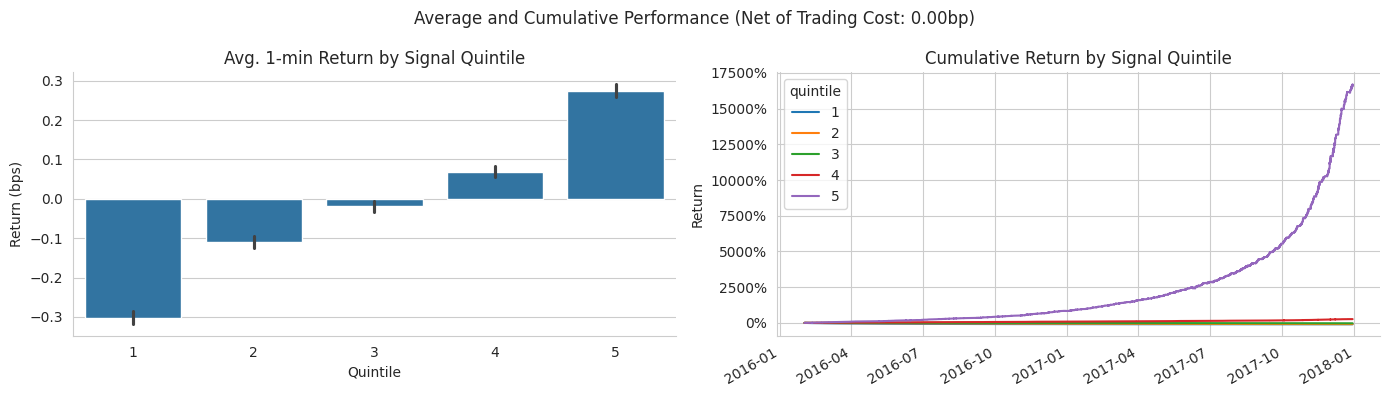

In [78]:
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=0)

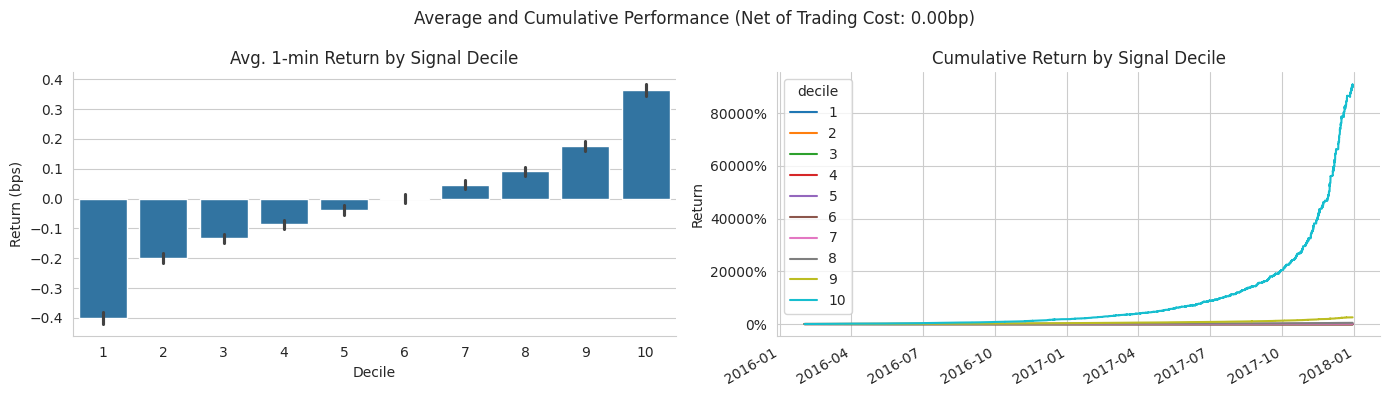

In [79]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=0)

##### With extremely low trading costs

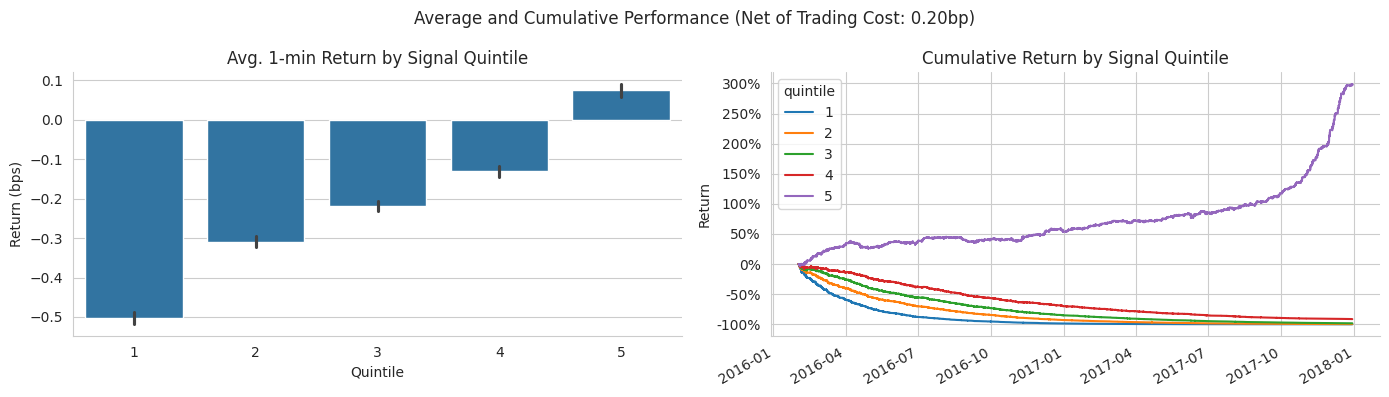

In [80]:
# assuming costs of a fraction of a basis point, close to the average return of the top quantile
plot_cumulative_performance(intraday_returns, 'quintile', trading_costs_bp=.2)

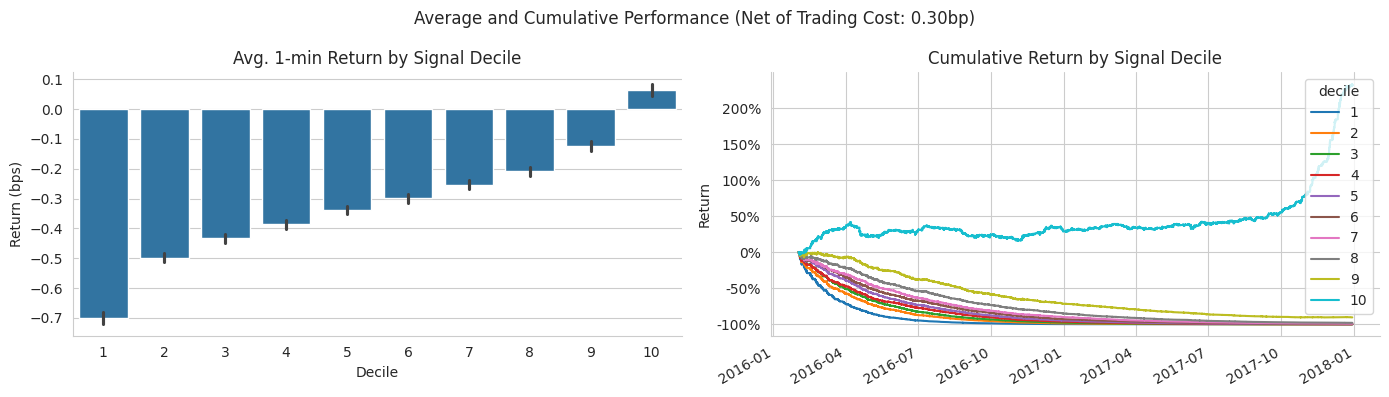

In [81]:
plot_cumulative_performance(intraday_returns, 'decile', trading_costs_bp=.3)

### Feature Importance

We'll take a quick look at the features that most contributed to improving the IC across the 23 folds:

In [82]:
with pd.HDFStore(result_store) as store:
    fi_keys = [k[1:] for k in store.keys() if k[1:].startswith('fi')]
    fi = pd.concat([store[k].to_frame(i) for i, k in enumerate(fi_keys, 1)], axis=1)

The top features from a conventional feature importance perspective are the ticker, followed by NATR, minute of the day, latest 1m return and the CCI:

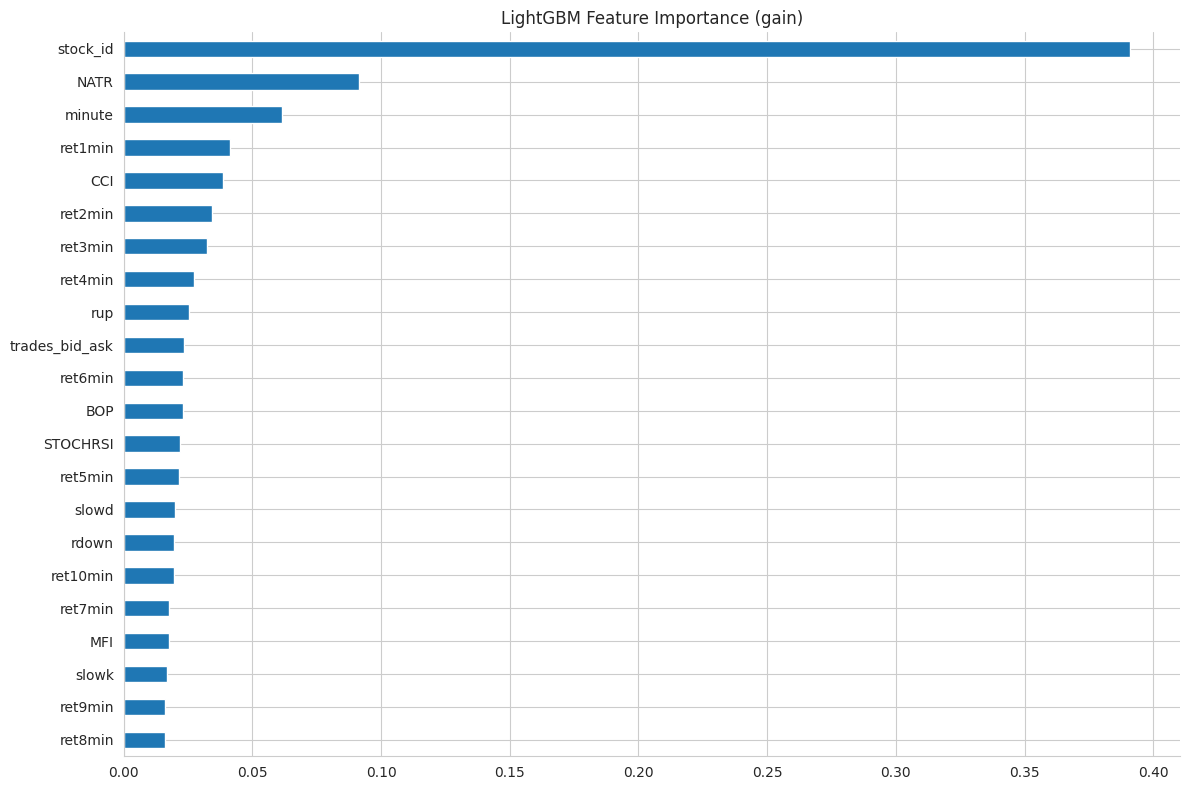

In [83]:
fi.mean(1).nsmallest(25).plot.barh(figsize=(12, 8), title='LightGBM Feature Importance (gain)')
sns.despine()
plt.tight_layout();

Explore with greater accuracy and in more detail how feature values affect predictions using SHAP values as demonstrated in various other notebooks in this Chapter and the appendix!

## Conclusion

We have seen that a relatively simple gradient boosting model is able to achieve fairly consistent predictive performance that is significantly better than a random guess even on a very short horizon. 

However, the resulting economic gains of our naive strategy of frequently buying/(short-)selling the top/bottome quantiles are too small to overcome the inevitable transaction costs. On the one hand, this demonstrates the challenges of extracting value from a predictive signal. On the other hand, it shows that we need a more sophisticated backtesting platform so that we can even begin to design and evaluate a more sophisticated strategy that requires far fewer trades to exploit the signal in our ML predictions. 

In addition, we would also want to work on improving the model by adding more informative feature, e.g. based on the quote/trade info contained in the Algoseek data, or by fine-tuning our model architecture and hyperparameter settings.